In [1]:
import numpy as np
import pandas as pd
import seaborn; seaborn.set()
from pmdarima import auto_arima
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import matplotlib.pylab as plt

In [2]:
LTCoct_df = pd.read_csv('../../Resources/LTC/LTC-USD_Historical_Oct-2021.csv',index_col='Date', parse_dates= True)
LTCoct_df.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-01,4.32912,4.945860,3.61359,4.07864,4.07864,2.746561e+08
2017-02-01,4.07604,4.131660,3.69848,3.77099,3.77099,1.490510e+08
2017-03-01,3.77306,7.074540,3.72948,6.66706,6.66706,4.890000e+08
2017-04-01,6.65316,16.072701,6.31102,15.70560,15.70560,2.678262e+09
2017-05-01,15.70810,37.328602,14.87570,25.29760,25.29760,6.499162e+09


In [3]:
LTCoct_df.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

In [4]:
LTCoct_df = LTCoct_df.drop(columns=['Open','High','Low','Adj Close','Volume'])

In [5]:
LTCoct_df.head(10)

,Close
Date,
2017-01-01,4.078640
2017-02-01,3.770990
2017-03-01,6.667060
2017-04-01,15.705600
2017-05-01,25.297600
2017-06-01,40.354301
2017-07-01,43.022701
2017-08-01,71.055099
2017-09-01,55.142399


In [6]:
LTCoct_df.dtypes

Close    float64
dtype: object

In [7]:
#help(seasonal_decompose)

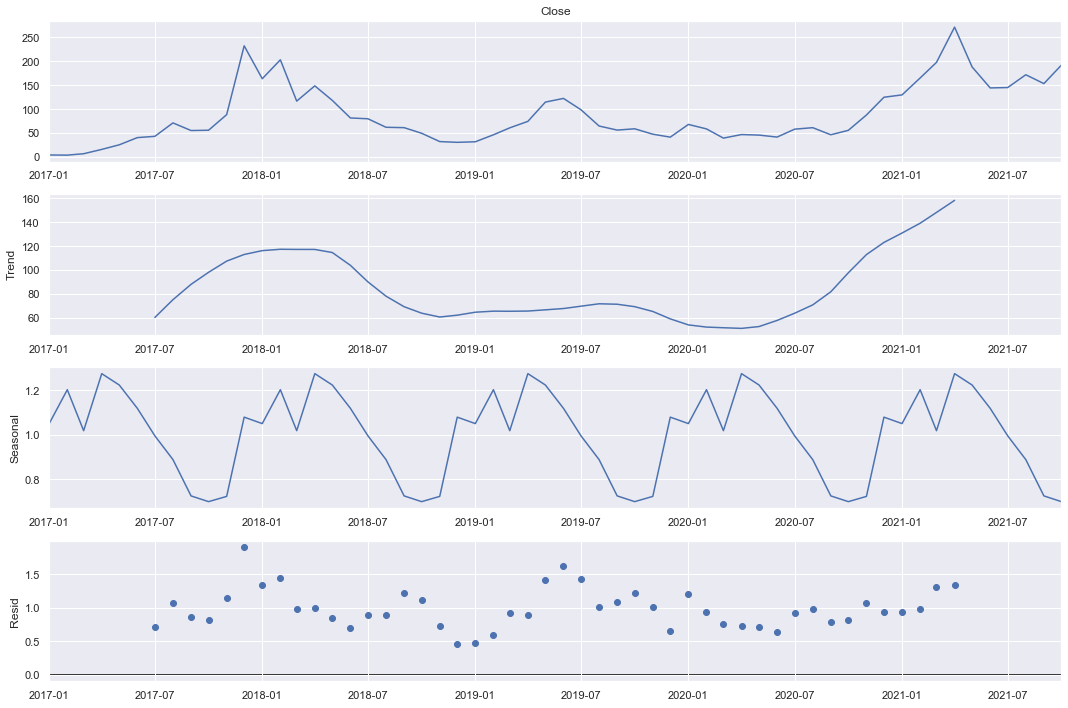

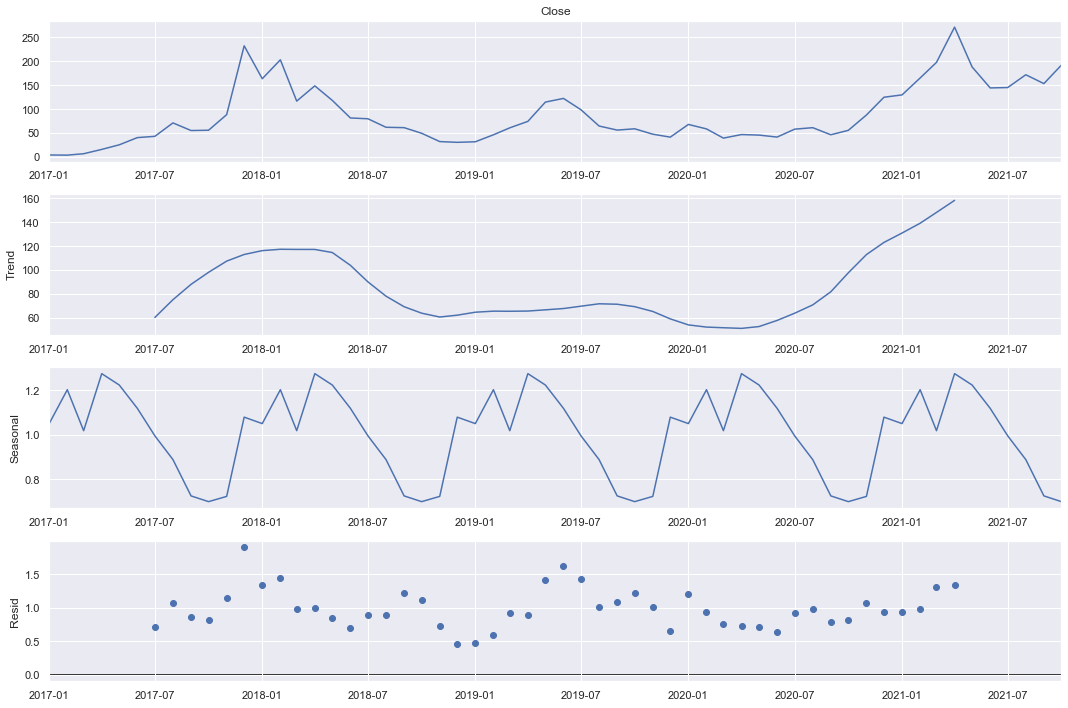

In [8]:
results = seasonal_decompose(LTCoct_df['Close'],model ='multiplicative',period=12)
plt.rcParams.update({'figure.figsize': (15,10)})
results.plot()

In [9]:
#Arima
import warnings
warnings.filterwarnings("ignore")

# Fit auto_arima function to LTC dataset
stepwise_fit = auto_arima(LTCoct_df['Close'], start_p = 0, start_q = 0,
max_p = 4, max_q = 4, m = 12,
start_P = 0, seasonal = True,
d = None, D = 1, trace = True,
error_action ='ignore', # we don't want to know if an order does not work
suppress_warnings = True, # we don't want convergence warnings
stepwise = True)# set to stepwise

# To print the summary
stepwise_fit.summary()


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=546.998, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=484.562, Time=0.09 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=549.647, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=487.242, Time=0.03 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=480.384, Time=0.26 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=522.276, Time=0.20 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=482.264, Time=0.30 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=482.297, Time=0.32 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=503.394, Time=0.27 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=483.085, Time=0.47 sec
 ARIMA(1,0,0)(2,1,0)[12]             : AIC=480.30

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   58
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -236.152
Date:                            Mon, 13 Dec 2021   AIC                            480.304
Time:                                    00:25:08   BIC                            487.618
Sample:                                         0   HQIC                           483.044
                                             - 58                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8889      0.077     11.546      0.000       0.738       1.040
ar.S.L12      -0.6852      0.179     -3.826      0.000      -1.036      -0.334
ar.S.L24      -0.4651      0.147     -3.172      0.002      -0.753      -0.178
sigma2      1359.4686    323.119      4.207      0.000     726.167    1992.770
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):                 2.22
Prob(Q):                              0.62   Prob(JB):                         0.33
Heteroskedasticity (H):               0.77   Skew:                            -0.40
Prob(H) (two-sided):                  0.61   Kurtosis:                         3.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
# Split data into train / test sets
train = LTCoct_df.iloc[:len(LTCoct_df)-12]
test = LTCoct_df.iloc[len(LTCoct_df)-12:] # set one year(12 months) for testing

# Fit a SARIMAX(1, 0, 0)x(2, 1, 0, 12) on the training set
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train['Close'],
order = (1, 0, 0),
seasonal_order =(2, 1, 0, 12))

result = model.fit()
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                   46
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood                   0.000
Date:                            Mon, 13 Dec 2021   AIC                              8.000
Time:                                    00:25:08   BIC                             14.105
Sample:                                01-01-2017   HQIC                            10.082
                                     - 10-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0000         -0        inf      0.000      -1.000      -1.000
ar.S.L12      -0.0002   1.69e-09     -9e+04      0.000      -0.000      -0.000
ar.S.L24       0.9998         -0       -inf      0.000       1.000       1.000
sigma2      2348.3673         -0       -inf      0.000    2348.367    2348.367
===================================================================================
Ljung-Box (L1) (Q):                    nan   Jarque-Bera (JB):                12.75
Prob(Q):                               nan   Prob(JB):                         0.00
Heteroskedasticity (H):                nan   Skew:                             0.00
Prob(H) (two-sided):                   nan   Kurtosis:                         0.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

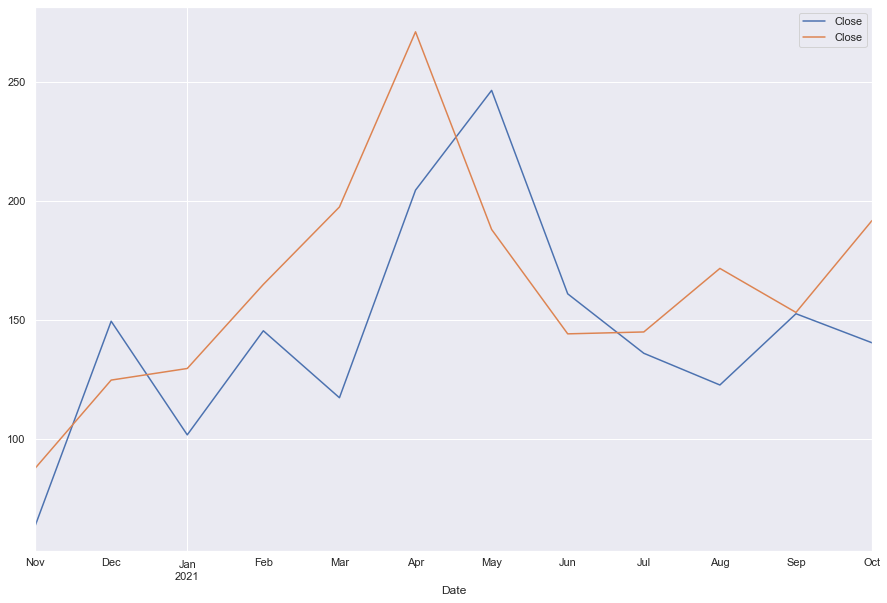

In [15]:
#Predictions of ARIMA Model agains the Test set
start = len(train)
end = len(train) + len(test) - 1

# Predictions for one-year against the test set
predictions = result.predict(start, end,typ = 'levels').rename("Close")

# plot predictions and actual values
predictions.plot(legend = True)
test['Close'].plot(legend = True)

In [16]:
#Evaluate the model using MSE and RMSE
# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Calculate root mean squared error
rmse(test["Close"], predictions)

42.882233057681

In [17]:
# Calculate mean squared error
mean_squared_error(test["Close"], predictions)

1838.8859120132693

Text(0, 0.5, 'Closing Amount (USD)')

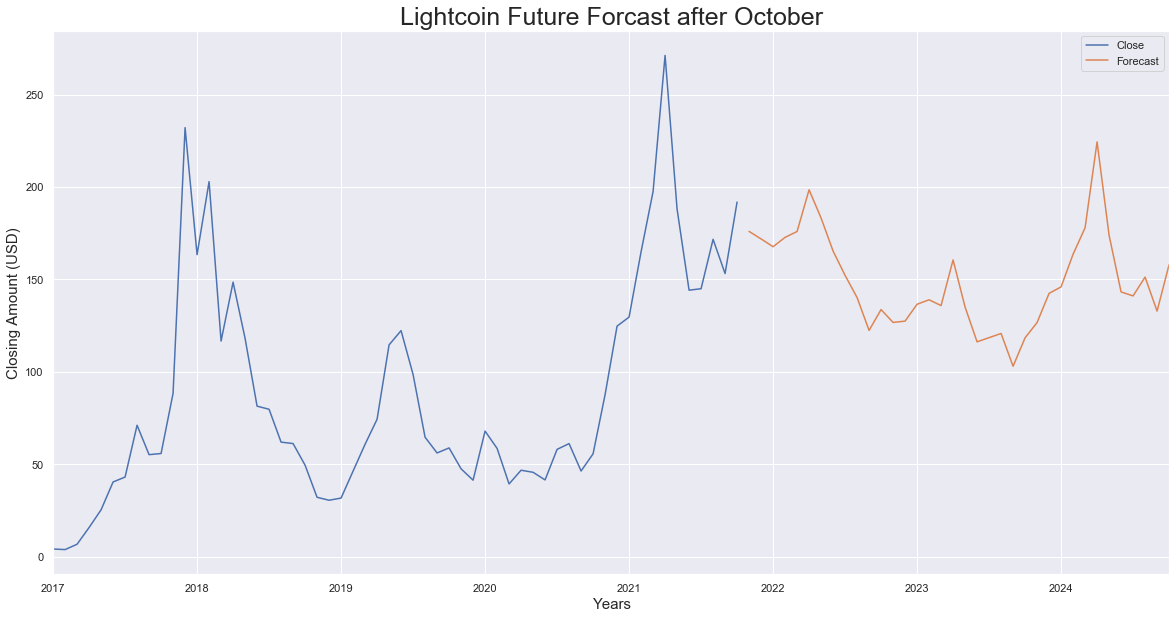

In [18]:
# Train the model on the full dataset
model = model = SARIMAX(LTCoct_df['Close'],order = (1, 0, 0),seasonal_order =(2, 1, 0, 12))
result = model.fit()

# Forecast for the next 3 years
forecast = result.predict(start = len(LTCoct_df),end = (len(LTCoct_df)-1) + 3 * 12,typ = 'levels').rename('Forecast')

# Plot the forecast values
LTCoct_df['Close'].plot(figsize = (20, 10), legend = True)
forecast.plot(legend = True)
plt.title("Lightcoin Future Forcast after October", fontsize = 25)
plt.xlabel('Years',fontsize=15)
plt.ylabel('Closing Amount (USD)',fontsize=15)